In [1]:
from scipy.io import wavfile
from scipy.fftpack import fft
from scipy import signal
import numpy as np
# Read the wav file

music = '1692887165610.wav'
sample_rate, data = wavfile.read(music)

from scipy.signal import butter, filtfilt


def highpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

data = data.sum(axis=1) / 2
cutoff = 86  # cutoff frequency in Hz
data = highpass_filter(data, cutoff, sample_rate)


In [2]:
# Perform the Fourier transform
frequencies, times, Zxx = signal.stft(data, fs=sample_rate, nperseg=sample_rate//5, noverlap=sample_rate//10)
mask = (frequencies > 40) & (frequencies < 8000)
frequencies = frequencies[mask]
Zxx = Zxx[mask, :]

len(times)

2060

In [3]:
# Take absolute value to get magnitude (power)
Zxx = np.abs(Zxx)

Zxx

array([[1.09970244e-08, 5.73517471e-01, 8.25855699e+00, ...,
        4.09805445e-70, 2.47562489e-77, 1.30105817e-84],
       [1.43888749e-08, 6.90397968e-01, 1.73641506e+01, ...,
        5.42229839e-70, 3.20184705e-77, 1.71789221e-84],
       [1.89386035e-08, 8.32239734e-01, 3.48874822e+01, ...,
        7.21148481e-70, 4.18323185e-77, 2.30934173e-84],
       ...,
       [3.59211891e-15, 3.57490134e-02, 3.22753781e+01, ...,
        4.78273647e-78, 7.81273484e-84, 3.07716878e-88],
       [4.08598008e-15, 3.52274355e-02, 2.45455302e+01, ...,
        4.77080273e-78, 7.79768996e-84, 3.07993529e-88],
       [3.57800236e-15, 3.47006323e-02, 1.09465166e+01, ...,
        4.75890637e-78, 7.78241289e-84, 3.08070838e-88]])

In [4]:
# Now you can perform your frequency binning on Zxx, just remember it needs to be done for each column (time step)
NUM_BINS = 5

bin_edges = np.logspace(np.log10(min(frequencies)+1), np.log10(max(frequencies)), NUM_BINS+1)
bin_medians = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(NUM_BINS)]
bin_freqs = np.digitize(frequencies, bins=bin_edges)
bin_vols_over_time = []
for t in range(Zxx.shape[1]):
    bin_vols = [np.sum(Zxx[bin_freqs==i, t]) for i in range(1, NUM_BINS+1)]
    bin_vols_over_time.append(bin_vols)
bin_vols_over_time = np.array(bin_vols_over_time)

In [5]:
bin_vols_over_time[20]

array([ 1745.38158287,  5466.93012777,  3786.9179194 ,  5363.54121134,
       15692.11895938])

In [6]:
for i in range(NUM_BINS):
    bin_vols_over_time[:, i] = bin_vols_over_time[:, i] / np.max(bin_vols_over_time[:, i])
# Scale to integer values for visualization
bin_vols_over_time = np.round(bin_vols_over_time * (13 - 1)).astype(int)
bin_vols_over_time[20]


array([1, 2, 1, 1, 3])

In [7]:
import matplotlib.pyplot as plt
# Create a new figure



ModuleNotFoundError: No module named 'matplotlib'

/var/folders/7l/92mph18d5nj1f6l32ly6l4zr0000gn/T/ipykernel_1583/190595986.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.plot(times, [20 * np.log10(vol_over_time[bin_index]) for vol_over_time in bin_vols_over_time], linewidth=0.5)


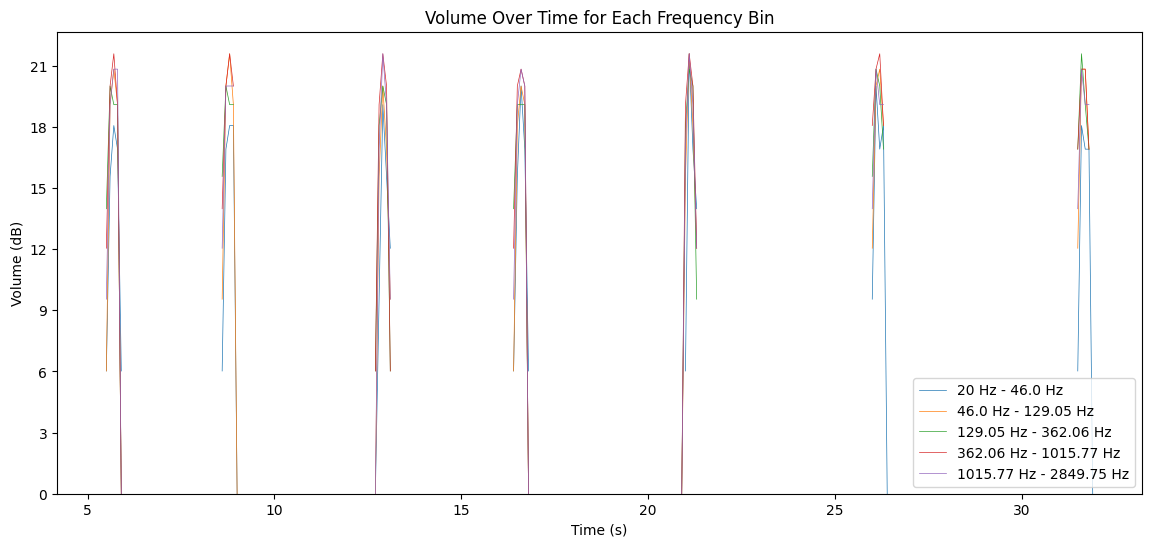

In [ ]:
# Create a new figure
plt.figure(figsize=(14, 6))

# Generate lines for each frequency bin
for bin_index in range(NUM_BINS):
    plt.plot(times, [20 * np.log10(vol_over_time[bin_index]) for vol_over_time in bin_vols_over_time], linewidth=0.5)

maxes = list(bin_edges)
maxes.append(9500)
mins = list(bin_edges)
mins.insert(0, 20)

# Add some labels
plt.xlabel('Time (s)')
plt.ylabel('Volume (dB)')
# Make the y label only display integer values
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.ylim(bottom=0)
plt.legend(['{} Hz - {} Hz'.format(round(mins[i],2), round(maxes[i],2)) for i in range(NUM_BINS)])
plt.title('Volume Over Time for Each Frequency Bin')

# Display the plot
plt.show()


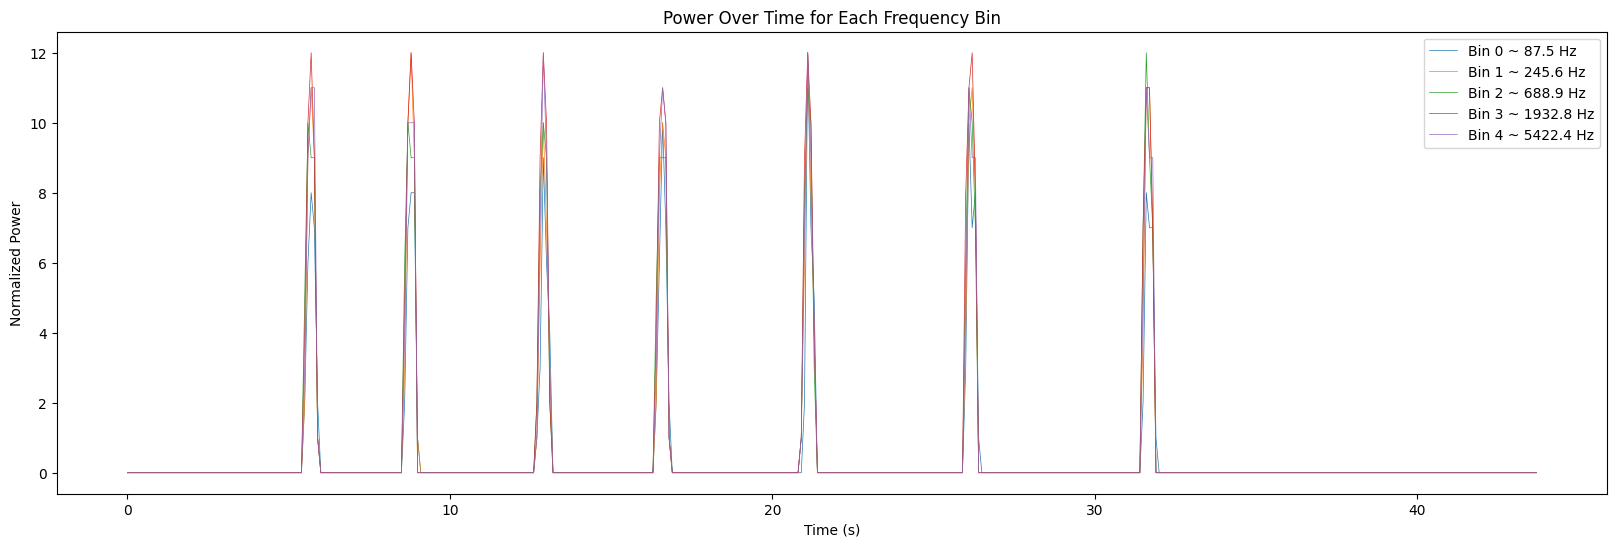

In [ ]:
# For each bin, we want to plot a line
plt.figure(figsize=(20, 6))

for i in range(NUM_BINS):
    # Get the power values of the current bin over time
    power_values = [vols[i] for vols in bin_vols_over_time]
    # Plot a line for the current bin
    plt.plot(times, power_values, label=f'Bin {i} ~ {bin_medians[i]:.1f} Hz', linewidth=0.5)

plt.xlabel('Time (s)')
plt.ylabel('Normalized Power')
plt.title('Power Over Time for Each Frequency Bin')
plt.legend()
plt.show()

In [ ]:
bin_medians

[87.52677549950631,
 245.5574170805363,
 688.914274964974,
 1932.75725039435,
 5422.373617010404]

In [ ]:
import pygame
import serial
import time
import threading

print(serial.__file__)

# Create a serial object
ser = serial.Serial('/dev/cu.usbmodem1301', 115200)

# Initialize the mixer module
pygame.mixer.init()

# Load the music file
pygame.mixer.music.load(music)

# Wait for connection to establish
time.sleep(1)

# Start threads to laucnh the music slightly after the serial connection is established
def play_music():
    time.sleep(0.12)
    pygame.mixer.music.play()

print("Starting music")
threading.Thread(target=play_music).start()
print("Music started")

# # Start playing the music
# pygame.mixer.music.play()

# Assuming your data is stored in bin_vols_over_time
for t in range(bin_vols_over_time.shape[0]):
    data = bin_vols_over_time[t]
    data_string = ",".join(map(str, data)) + "\n"
    ser.write(data_string.encode())

#     # Wait for a tenth of a second before sending the next data
    time.sleep(0.098)



# Close the serial connection
ser.close()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/serial/__init__.py
Starting music
Music started


KeyboardInterrupt: 

In [ ]:
pygame.mixer.music.stop()
ser.close()